 # Satellite Image Time Series (SITS) R package
<hr style="border:2px solid #0077b9;">

- Rolf Simões <rolf.simoes@inpe.br>
- Gilberto Ribeiro <gilberto.queiroz@inpe.br>
- Vitor Gomes <vitor.gomes@inpe.br>

## Overview
<hr style="border:2px solid #0077b9;">
<center>
<img src="./imgs/overview.png" alt="SITS package process overview" style="width: 800px;"/>
</center>

## Sample
<hr style="border:2px solid #0077b9;">
<center>
<img src="./imgs/sits_table.png" alt="SITS table" style="width: 800px;"/>
</center>

### Load data from WTSS

In [1]:
# load sits library
library(sits)

# data access: sits_getdata() function
# WTSS service
URL <- "http://www.dpi.inpe.br/tws/wtss"
wtss_inpe <- sits_infoWTSS(URL)

Satellite Image Time Series package.
Loaded sits v0.11.24. See ?sits for help, citation("sits") for use in publication.

Registering TWDTW distance from `dtwSat` into `proxy::pr_DB`.



-----------------------------------------------------------
The WTSS server URL is http://www.dpi.inpe.br/tws/wtss
Available coverages: 
MOD13Q1
itobi
merge
mod13q1_512
------------------------------------------------------------


In [2]:
# get information about a specific coverage
coverage <- "mod13q1_512"
coverage.tb <- sits_coverageWTSS(URL, coverage)

----------------------------------------------------------------------------------
Coverage: mod13q1_512
Description: Vegetation Indices 16-Day L3 Global 250m
Source: https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod13q1
Bands: 
  name                            description
1 ndvi                      250m 16 days NDVI
2  evi                       250m 16 days EVI
3  red  250m 16 days red reflectance (Band 1)
4  nir  250m 16 days NIR reflectance (Band 2)
5 blue 250m 16 days blue reflectance (Band 3)
6  mir  250m 16 days MIR reflectance (Band 7)

Spatial extent: (-180, -90) - (180, 90)
Spatial resolution: (0.00208334, 0.00208334)
Projection CRS: +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs
Time range: 2000-02-18 to 2017-02-18
Temporal resolution: 16 days 
----------------------------------------------------------------------------------


In [3]:
# select a point in the Mato Grosso
longitude <- -55.5027
latitude  <- -11.7181

# choose a coverage
bands <-  c("ndvi", "evi", "nir", "mir")

# retrieve the time series associated with the point from the WTSS server
point.tb <- sits_getdata(latitude = latitude,
                         longitude = longitude,
                         bands = bands,
                         URL = URL,
                         coverage = coverage,
                         start_date = "2010-09-01",
                         end_date = "2011-08-31")

# show the data
print(point.tb)

# A tibble: 1 x 7
  longitude latitude start_date   end_date   label    coverage
      <dbl>    <dbl>     <date>     <date>   <chr>       <chr>
1  -55.5027 -11.7181 2010-09-01 2011-08-31 NoClass mod13q1_512
# ... with 1 more variables: time_series <list>


### Select bands to compose time series data samples

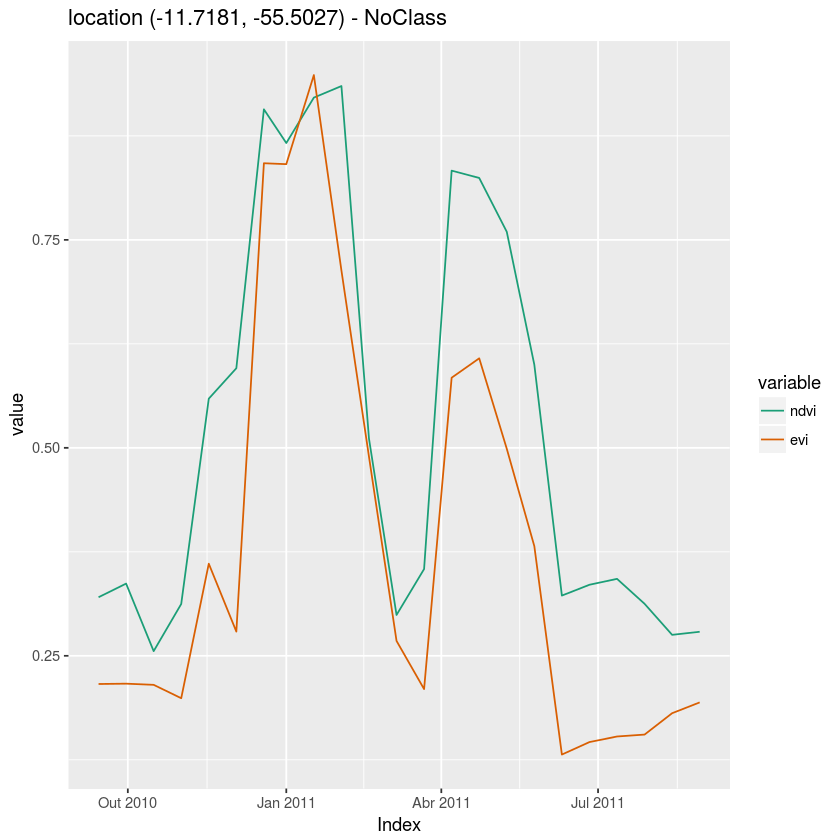

In [4]:
point.tb <- sits_select(point.tb, bands = c("ndvi", "evi"))
sits_plot(point.tb)

### Load WTSS data using a CSV file

In [5]:
samples.tb <- sits_getdata(file = "./data/samples.csv", bands = bands, coverage = coverage)
print(samples.tb)

# A tibble: 10 x 7
   longitude  latitude start_date   end_date   label    coverage
       <dbl>     <dbl>     <date>     <date>   <chr>       <chr>
 1 -54.23130 -14.04820 2014-09-14 2015-08-29 Cerrado mod13q1_512
 2 -54.22900 -14.06320 2014-09-14 2015-08-29 Cerrado mod13q1_512
 3 -55.20920 -15.11460 2014-09-14 2015-08-29 Cerrado mod13q1_512
 4 -55.35270 -15.07390 2014-09-14 2015-08-29 Cerrado mod13q1_512
 5 -55.32420 -15.07600 2014-09-14 2015-08-29 Cerrado mod13q1_512
 6 -51.24116 -14.07031 2013-09-14 2014-08-29  Forest mod13q1_512
 7 -49.41576 -22.54451 2013-09-14 2014-08-29  Forest mod13q1_512
 8 -51.28603 -13.65523 2013-09-14 2014-08-29  Forest mod13q1_512
 9 -50.65513 -12.43026 2013-09-14 2014-08-29  Forest mod13q1_512
10 -51.25767 -14.21321 2013-09-14 2014-08-29  Forest mod13q1_512
# ... with 1 more variables: time_series <list>


### Load sample data from raster file

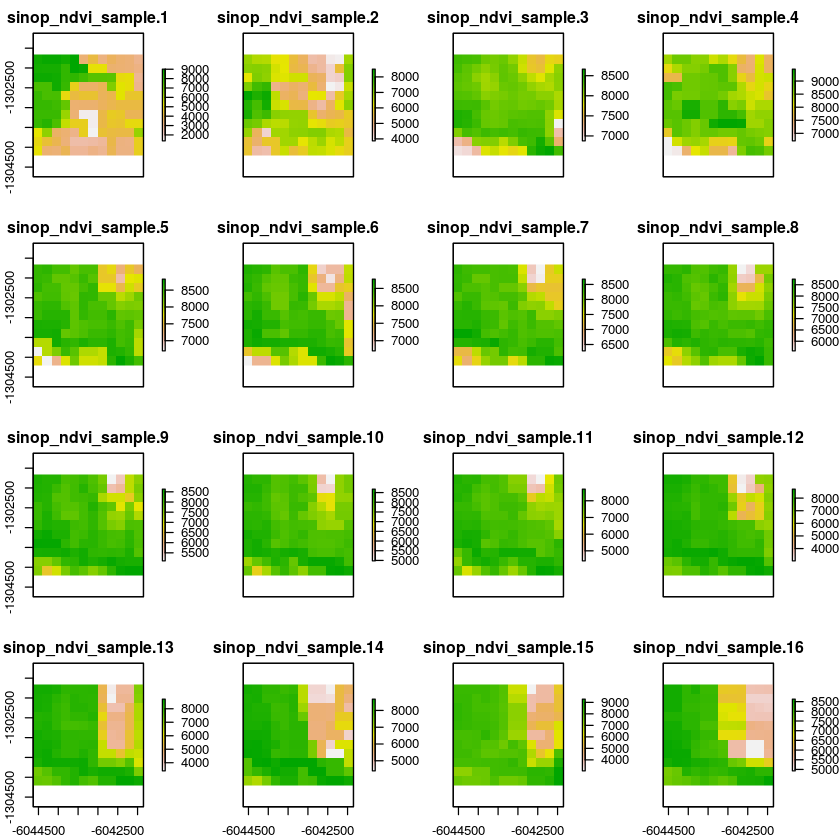

In [14]:
# raster data source
# select the files for processing
files <- c(system.file("extdata/raster/mod13q1/sinop_ndvi_sample.tif",
                       package = "sits"))
# select the bands
bands <- c("ndvi")

# define the scale factors
scale_factors <- c(0.0001)

# get the image timeline from a CSV file
timeline <- read.csv(system.file("extdata/raster/mod13q1/mod13Q1-timeline-2000-2017.csv",
                                 package = "sits"), header = FALSE)
timeline <- lubridate::as_date (timeline$V1)

# create a raster metadata file based on the information about the files
raster.tb <- sits_STRaster(files, timeline, bands,
                           scale_factors)

# select a location to read
longitude <- -55.5027
latitude  <- -11.7181

# test the data by reading a point
point.tb <- sits_getdata(raster.tb = raster.tb,
                         longitude = longitude,
                         latitude = latitude)

# show images for the first 16 time steps
raster::plot(raster.tb$r_obj[[1]])

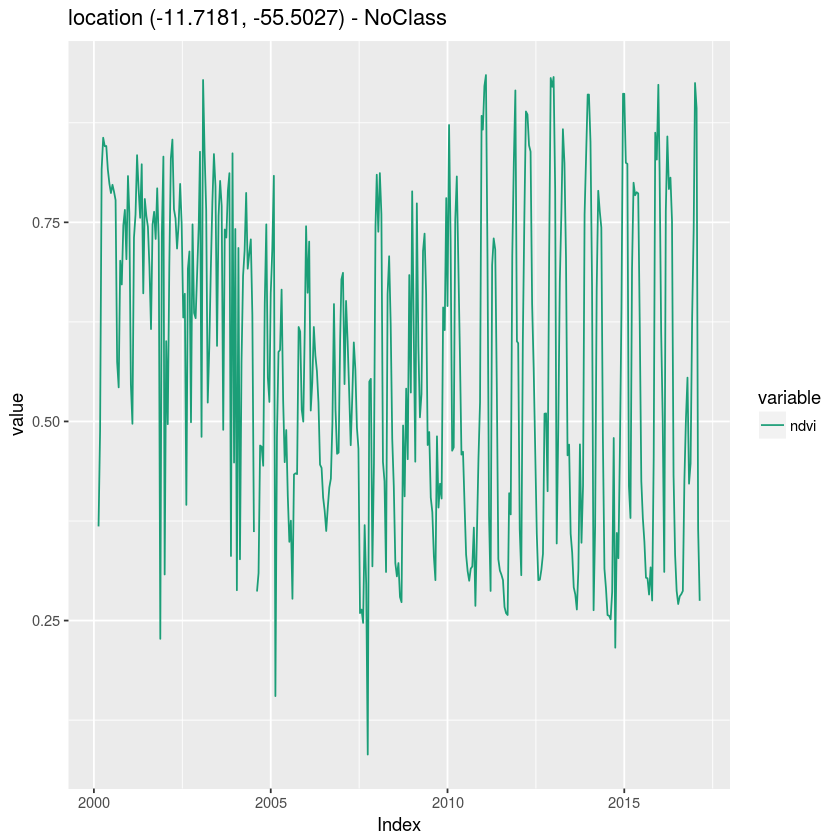

In [15]:
# plot the time series for the point
sits_plot(point.tb)

## Filtering
<hr style="border:2px solid #0077b9;">
SITS provides some filtering functions that can be combined together to reduce noise in time series. These functions include:
- sits_whittaker()
- sits_envelope()
- sits_cloud_filter()

Besides filtering SITS offers functions to treat missing values.
- sits_linear_interp()

### Removing time series missing values using interpolation 

In [10]:
# time series has one NA value
which(is.na(point.tb$time_series[[1]]))

[1] 495

In [11]:
# Use the na.spline from *zoo* package to remove NA values
# We pass it to sits_apply function to apply it on all bands 
point.tb <- sits_apply(point.tb, zoo::na.spline, function(x){x}, "")

# time series has no NA value!
which(is.na(point.tb$time_series[[1]]))

integer(0)

After removing NA values, we can perform filtering on time series.
We use sits_merge function to **merge** original time series and filtered time series in the same table. 

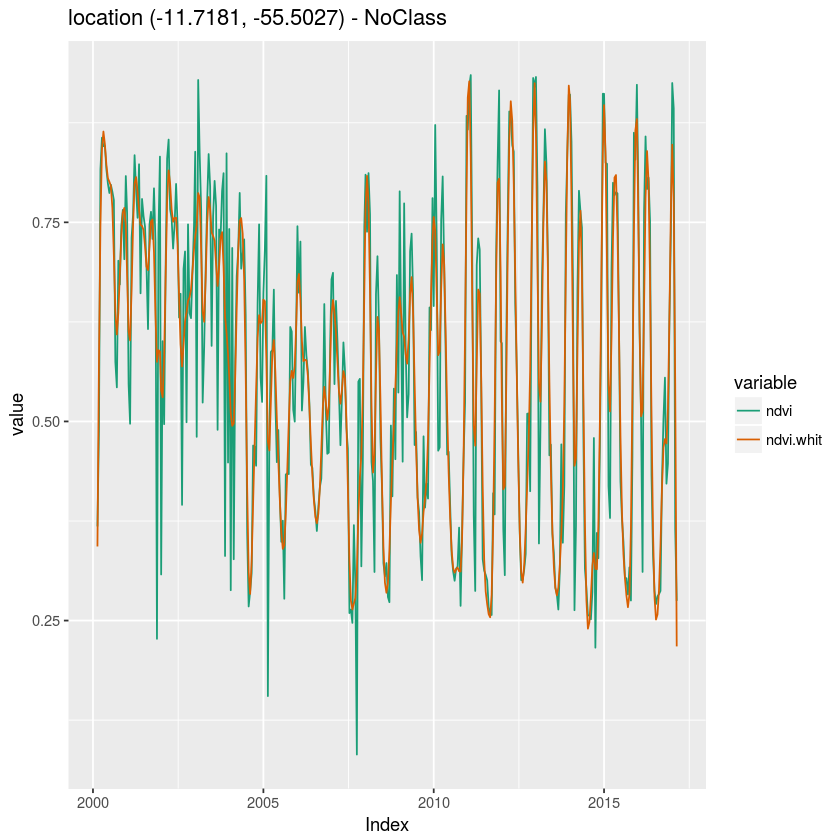

In [77]:
# Whittaker filter
sits_plot(sits_merge(point.tb, sits_whittaker(point.tb)))

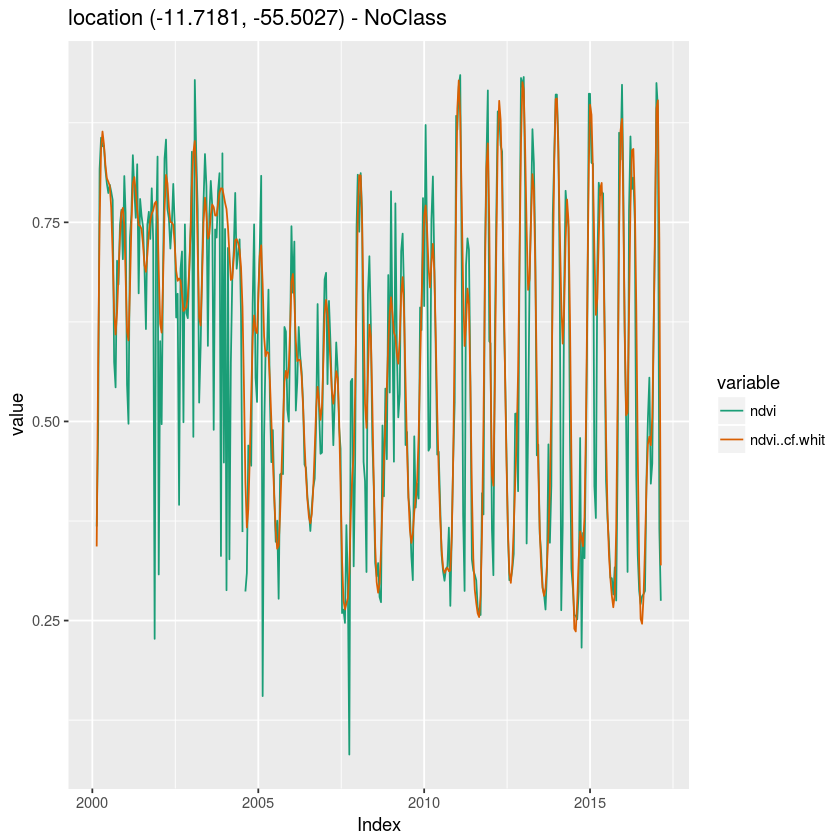

In [30]:
# Cloud filter
sits_plot(sits_merge(point.tb, sits_cloud_filter(point.tb)))

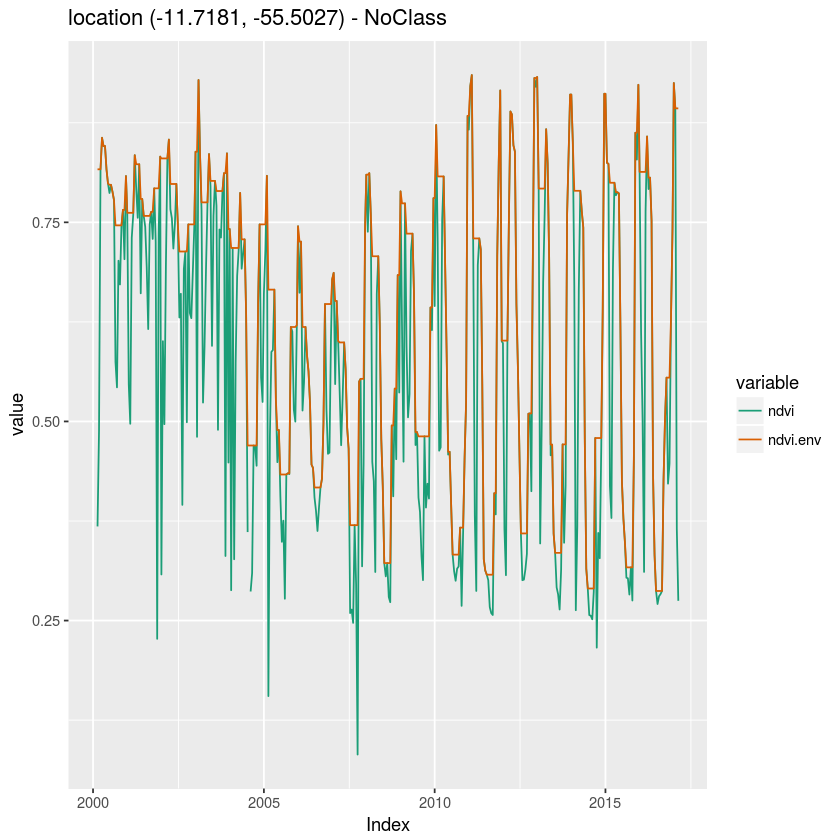

In [31]:
# Envelope
sits_plot(sits_merge(point.tb, sits_envelope(point.tb, "UULL")))

## Clustering
<hr style="border:2px solid #0077b9;">
SITS provides aglomerative hierarchical clustering. The procedure consists in compute a dendrogram followed by th cut tree at some level. The functions for clustering are:
- sits_dendrogram()
- sits_cluster()
- sits_plot_dendrogram()

In [25]:
# retrieve the samples from EMBRAPA
samples.tb <- readRDS("./data/embrapa_mt.rds")
print(sits_labels(samples.tb))

# A tibble: 9 x 3
          label count       freq
          <chr> <int>      <dbl>
1       Cerrado   400 0.18912530
2 Fallow_Cotton    34 0.01607565
3        Forest   138 0.06524823
4       Pasture   370 0.17494090
5      Soy_Corn   398 0.18817967
6    Soy_Cotton   399 0.18865248
7    Soy_Fallow    88 0.04160757
8    Soy_Millet   235 0.11111111
9 Soy_Sunflower    53 0.02505910


In [26]:
# compute de AHC and returns a dendrogram to be cutted at some level
dendro <- sits_dendrogram(samples.tb)

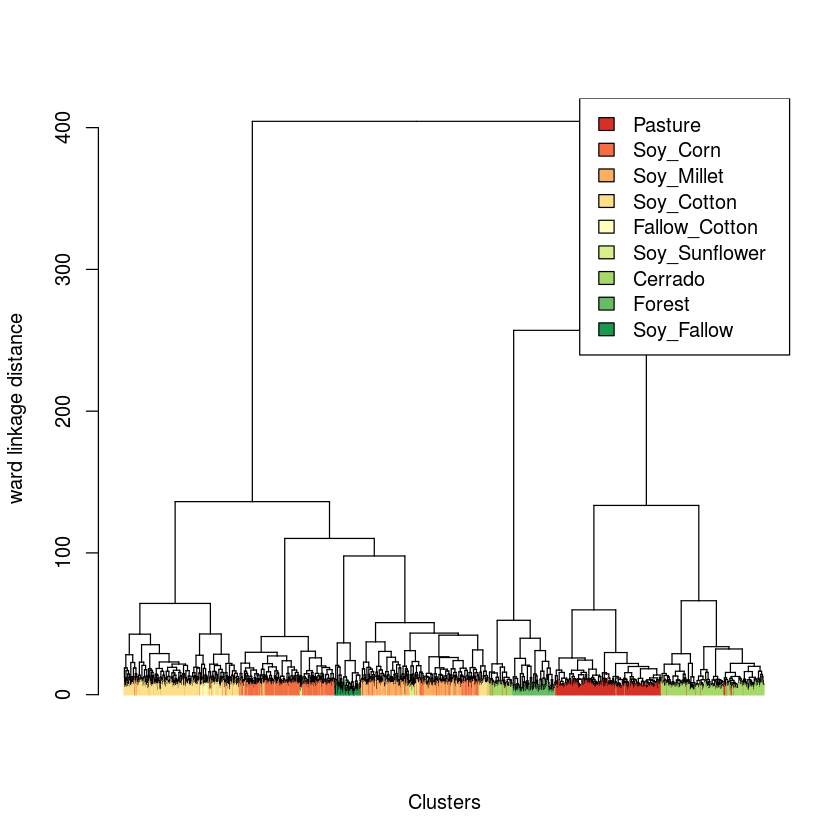

In [28]:
# plot the dendrogram
sits_plot_dendrogram(samples.tb, dendro)

In [34]:
# to create an unsupervised classification we call sits_cluster() function
clusters.tb <- sits_cluster(samples.tb, dendro, k = 10)
print(clusters.tb)

# A tibble: 2,115 x 8
   longitude latitude start_date   end_date   label    coverage
       <dbl>    <dbl>     <date>     <date>   <chr>       <chr>
 1  -55.1852 -10.8378 2013-09-14 2014-08-29 Pasture mod13q1_512
 2  -57.7940  -9.7573 2006-09-14 2007-08-29 Pasture mod13q1_512
 3  -51.9412 -13.4198 2014-09-14 2015-08-29 Pasture mod13q1_512
 4  -55.9643 -10.0621 2005-09-14 2006-08-29 Pasture mod13q1_512
 5  -54.5540 -10.3749 2013-09-14 2014-08-29 Pasture mod13q1_512
 6  -52.4572 -10.9512 2013-09-14 2014-08-29 Pasture mod13q1_512
 7  -52.1443 -13.9981 2013-09-14 2014-08-29 Pasture mod13q1_512
 8  -57.6907 -13.3382 2015-09-14 2016-08-28 Pasture mod13q1_512
 9  -54.7034 -16.4265 2015-09-14 2016-08-28 Pasture mod13q1_512
10  -53.6543 -15.7155 2014-09-14 2015-08-29 Pasture mod13q1_512
# ... with 2,105 more rows, and 2 more variables: time_series <list>,
#   cluster <int>


In [42]:
# prints a cluster Vs. class matrix
print(sits_cluster_frequency(clusters.tb))

               
                   1    2    3    4    5    6    7    8    9   10 Total
  Cerrado          3    3  211   74  109    0    0    0    0    0   400
  Fallow_Cotton    0    0    0    0    0    3    0   31    0    0    34
  Forest           0    0    0  138    0    0    0    0    0    0   138
  Pasture        154  192   16    5    2    1    0    0    0    0   370
  Soy_Corn         0    1    0    0    0  103  279    8    7    0   398
  Soy_Cotton       0    0    0    0    0   59   12  117  210    1   399
  Soy_Fallow       0    0    0    0    0    0    0    0    0   88    88
  Soy_Millet       0    1    0    0    0  225    5    2    2    0   235
  Soy_Sunflower    0    0    0    0    0   30   19    0    4    0    53
  Total          157  197  227  217  111  421  315  158  223   89  2115


In [24]:
#select the bands for classification
print(sits_bands(samples.tb))
samples.tb <- sits_select(samples.tb, bands = c("ndvi"))

[1] "ndvi"


Applying GAM to get time series patterns...


  |======================================================================| 100%


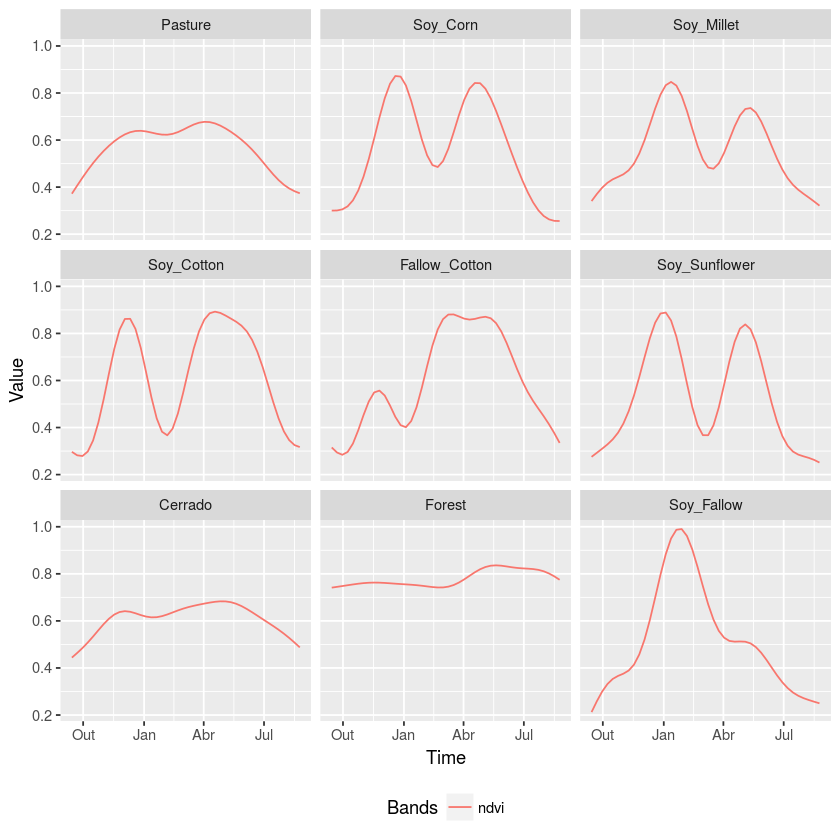

In [25]:
# how can we produce a representative time series pattern for each class?
# define the patterns from data with GAM
patterns.tb <- sits_patterns(samples.tb)

# plot the patterns
sits_plot(patterns.tb)

In [43]:
# SVM
classification.tb <-
    sits_classify(point.tb, samples.tb,
                  sits_svm(cost = 1000,
                           kernel = "radial",
                           tolerance = 0.001,
                           epsilon = 0.1))
sits_plot(classification.tb)

ERROR: Error in `[.data.frame`(distances.tb, r, idx[(2 * b - 1)]:idx[2 * b]): undefined columns selected


# weights:  225 (192 variable)
initial  value 4647.129981 
iter  10 value 2401.242859
iter  20 value 1174.363172
iter  30 value 1077.563380
iter  40 value 1041.454356
iter  50 value 1024.307862
iter  60 value 1014.833881
iter  70 value 1010.833618
iter  80 value 1007.071816
iter  90 value 1003.723683
iter 100 value 1001.505991
final  value 1001.505991 
stopped after 100 iterations


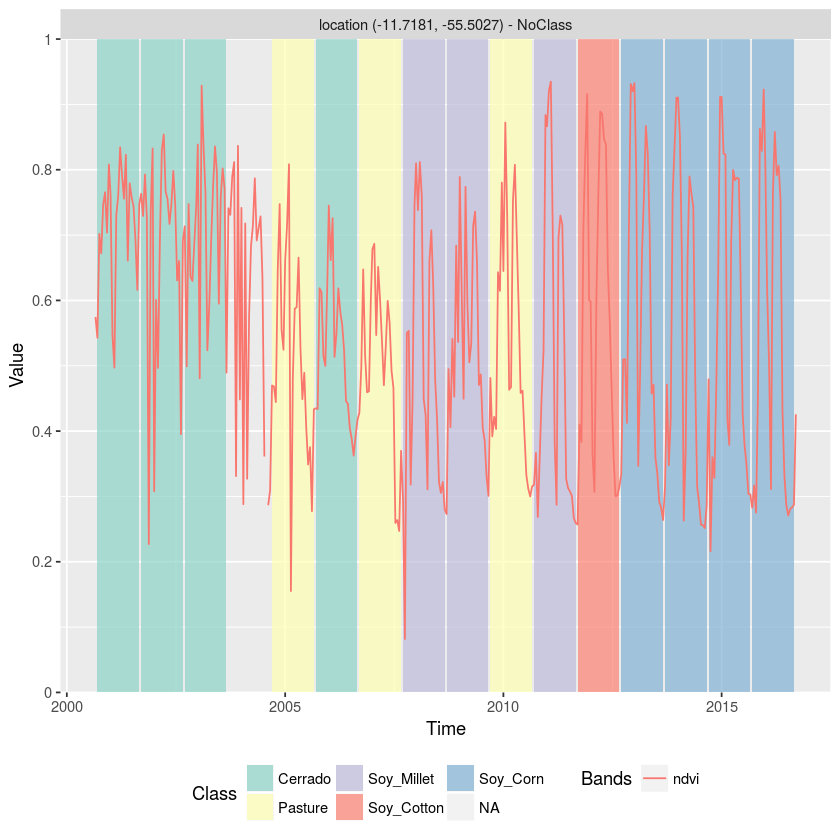

In [27]:
# Multinomial Log-Linear
classification.tb <-
    sits_classify(point.tb, samples.tb, sits_mlr())
sits_plot(classification.tb)

In [30]:
# classify the raster image
raster_result.tb <- 
    sits_classify_raster(file = "~/Downloads/embrapa-class",
                         raster.tb, samples.tb,
                         sits_svm(cost = 1000,
                                  kernel = "radial",
                                  tolerance = 0.001,
                                  epsilon = 0.1),
                         blocksize = 300000, multicores = 1)

print(raster_result.tb)

# A tibble: 16 x 17
               r_obj ncols nrows  band start_date   end_date   timeline
              <list> <int> <int> <chr>     <date>     <date>     <list>
 1 <S4: RasterLayer>    12    11 class 2000-09-13 2001-08-29 <date [2]>
 2 <S4: RasterLayer>    12    11 class 2001-09-14 2002-08-29 <date [2]>
 3 <S4: RasterLayer>    12    11 class 2002-09-14 2003-08-29 <date [2]>
 4 <S4: RasterLayer>    12    11 class 2003-09-14 2004-08-28 <date [2]>
 5 <S4: RasterLayer>    12    11 class 2004-09-13 2005-08-29 <date [2]>
 6 <S4: RasterLayer>    12    11 class 2005-09-14 2006-08-29 <date [2]>
 7 <S4: RasterLayer>    12    11 class 2006-09-14 2007-08-29 <date [2]>
 8 <S4: RasterLayer>    12    11 class 2007-09-14 2008-08-28 <date [2]>
 9 <S4: RasterLayer>    12    11 class 2008-09-13 2009-08-29 <date [2]>
10 <S4: RasterLayer>    12    11 class 2009-09-14 2010-08-29 <date [2]>
11 <S4: RasterLayer>    12    11 class 2010-09-14 2011-08-29 <date [2]>
12 <S4: RasterLayer>    12    11 class 2011-